# Development Testing

Notebook Author: Koki Sasagawa
Date: 11/14/2018

Run tests using the development data to evaluate where the algorithm has weak performance. 

## Data:
1. `labeled-vertives.dev.tsv`
2. `labeled-verties.train.tsv`
3. `network.tsv` 

## Running the Notebook
This notebook requires the `nalgorithm.py` and `decorators.py` files

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time
from nalgorithm import candidate_node
from decorators import timer
%matplotlib inline

## 1. Create Graph

In [4]:
print("Creating network graph...")
start_time = time.perf_counter() 

with open("../raw_data/network.tsv", 'rb') as f:
    grph = nx.read_edgelist(path=f, delimiter='\t', encoding='utf8')

end_time = time.perf_counter() 
print("Network graph created. Process took {:.04f} seconds".format(end_time - start_time))

# Check that graph is of correct size
print("Number of edges: {}".format(grph.number_of_edges())) # There should be 30915267
print("Number of nodes: {}".format(grph.number_of_nodes())) # There should be 6626753

Creating network graph...
Network graph created. Process took 344.5233 seconds
Number of edges: 30915267
Number of nodes: 6626753


## 2. Load all files

In [5]:
@timer
def load_data(file_name):
    chunks = pd.read_csv(file_name, 
                         delimiter='\t',
                         names=['id', 'attr'],
                         header=None,
                         chunksize=100000)

    output = pd.concat(chunks)
    
    return output

In [6]:
dev_set = load_data('../raw_data/labeled-vertices.dev.tsv')

print('Total number of nodes: {}'.format(dev_set.shape[0]))
dev_set.head()

Running load_data...
Finished in 0.3488s
Total number of nodes: 662675


,id,attr
0,2666403,T0:2 T1:99
1,2627940,T0:0 T1:26
2,4843136,T0:0 T1:26
3,5396835,T0:0 T1:1813
4,5438188,T0:1 T1:1733


In [7]:
train_set = load_data('../raw_data/labeled-vertices.train.tsv')

print('Total number of nodes: {}'.format(train_set.shape[0]))
train_set.head()

Running load_data...
Finished in 1.9489s
Total number of nodes: 5301403


,id,attr
0,5509623,T0:0 T1:0
1,6334893,T0:0 T1:1
2,1218900,T0:1 T1:2
3,3871398,T0:1 T1:2
4,3942361,T0:0 T1:3


In [59]:
tot_set = pd.concat([train_set, dev_set]).reset_index(drop=True)
tot_set = tot_set.drop_duplicates(keep='first')

print('Total number of nodes: {}'.format(tot_set.shape[0]))
tot_set.head()

Total number of nodes: 5964078


,id,attr
0,5509623,T0:0 T1:0
1,6334893,T0:0 T1:1
2,1218900,T0:1 T1:2
3,3871398,T0:1 T1:2
4,3942361,T0:0 T1:3


## 3. Generate Predictions

In [8]:
dev_set['id'] = dev_set['id'].astype(str)

In [9]:
candidate_node = timer(candidate_node)

In [10]:
preferential_attachment_nodes = candidate_node(test_set=dev_set['id'], grph=grph, algo_type='preferential attachment')

Running candidate_node...
Finished in 23.8137s


In [11]:
adamic_adar_nodes = candidate_node(test_set=dev_set['id'], grph=grph, algo_type='adamic/adar')

Running candidate_node...
Finished in 20.4862s


In [13]:
# Adamic/Adar + Preferential Attachment
predictions = pd.DataFrame({'id': dev_set['id'],
                            'attr': list(adamic_adar_nodes.values()), 
                            'attr2': list(preferential_attachment_nodes.values())})

preferential_attachment_nodes = None
adamic_adar_nodes = None

## 4. Combine predictions from Adamic/Adar with preferential attachment

In [14]:
# Number of times where candidate node does not exist
zeros = predictions.shape[0] - np.count_nonzero(predictions['attr'])
print("Missing candidate nodes: {}".format(zeros))

print('Replacing 0\'s with nodes from preferential attachment...')
# Replace 0's with nodes selected by preferential attachment
predictions['attr'] = np.where(predictions['attr'] == 0, predictions['attr2'], predictions['attr'])
zeros = predictions.shape[0] - np.count_nonzero(predictions['attr'])
print("Missing candidate nodes: {}".format(zeros))

predictions.drop(['attr2'], axis=1, inplace=True)

Missing candidate nodes: 140181
Replacing 0's with nodes from preferential attachment...
Missing candidate nodes: 0


## 5. Obtain attributes for predicted nodes

In [15]:
print("There are {} rows in the prediction dataframe".format(predictions.shape[0]))
predictions.head()

There are 662675 rows in the prediction dataframe


,id,attr
0,2666403,2051632
1,2627940,4843136
2,4843136,2627940
3,5396835,2352112
4,5438188,5690565


In [16]:
# Check dtype
print('dtype of id in train_set is {}'.format(type(train_set['id'][0])))
print('dtype of id in predictions is {}'.format(type(predictions['attr'][0])))

dtype of id in train_set is <class 'numpy.int64'>
dtype of id in predictions is <class 'str'>


In [17]:
# The values in the prediction dataframe are currently str type
# convert them to int64 to allow merge with train_set
predictions = predictions.astype(dtype=np.int64, copy=True)
print('dtype of id in predictions is {}'.format(type(predictions['attr'][0])))

dtype of id in predictions is <class 'numpy.int64'>


In [22]:
results = predictions.merge(train_set, left_on='attr', right_on='id', how='left')
results.head()

,id_x,attr_x,id_y,attr_y
0,2666403,2051632,2051632.0,T0:2 T1:99
1,2627940,4843136,NaN,NaN
2,4843136,2627940,NaN,NaN
3,5396835,2352112,2352112.0,T0:0 T1:1813
4,5438188,5690565,5690565.0,T0:1 T1:1733


In [23]:
print('nan values:\n{}'.format(results.isna().sum()))

nan values:
id_x          0
attr_x        0
id_y      45764
attr_y    45764
dtype: int64


In the train set, there are 45764 nodes that do not exist. For these nodes, we can't predict their attributes so drop these rows.

In [24]:
results.dropna(inplace=True)

In [25]:
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)
results.columns = ['id', 'attr']
print('Results table has {} rows'.format(results.shape[0]))
results.head()

Results table has 616911 rows


,id,attr
0,2666403,T0:2 T1:99
3,5396835,T0:0 T1:1813
4,5438188,T0:1 T1:1733
5,1394998,T0:0 T1:20
6,174985,T0:0 T1:87


## 6. Merge attributes for development set 

In [27]:
# Check dtype
print('dtype of id in dev_set is {}'.format(type(dev_set['id'][0])))

dtype of id in dev_set is <class 'str'>


In [28]:
# Convert dtype to int64 to merge with results
dev_set['id'] = dev_set['id'].astype(np.int64)

In [34]:
dev_results = results.merge(dev_set, left_on='id', right_on='id', how='left')
dev_results.head()

,id,attr_x,attr_y
0,2666403,T0:2 T1:99,T0:2 T1:99
1,5396835,T0:0 T1:1813,T0:0 T1:1813
2,5438188,T0:1 T1:1733,T0:1 T1:1733
3,1394998,T0:0 T1:20,T0:0 T1:653
4,174985,T0:0 T1:87,T0:0 T1:87


In [35]:
dev_results.rename(columns={'attr_x': 'prediction', 'attr_y': 'true'}, inplace=True)

In [36]:
# If attributes are equal, assign True, else False
dev_results = dev_results.assign(NE = dev_results['true'] == dev_results['prediction'])
dev_results.head()

,id,prediction,true,NE
0,2666403,T0:2 T1:99,T0:2 T1:99,True
1,5396835,T0:0 T1:1813,T0:0 T1:1813,True
2,5438188,T0:1 T1:1733,T0:1 T1:1733,True
3,1394998,T0:0 T1:20,T0:0 T1:653,False
4,174985,T0:0 T1:87,T0:0 T1:87,True


## 4. Evaluate performance

In [37]:
true_pred = dev_results[dev_results['NE'] == True]
false_pred = dev_results[dev_results['NE'] == False]

print('Prediction results\n')
print('Correct predictions: {}'.format(true_pred.shape[0]))
print('Wrong predictions: {}'.format(false_pred.shape[0]))
print('Proportion correct: {:.2f}'.format((true_pred.shape[0] / dev_results.shape[0]) * 100))

Prediction results

Correct predictions: 390889
Wrong predictions: 226022
Proportion correct: 63.36


The performance is around 63.36%. The Adamic/Adar index and preferential attachment both rely on shared links between nodes. Perhaps, the poor performance is due to nodes with low connectivity.

### Plot the average degree of nodes for wrongly and correctly predicted attribute sets

In [47]:
@timer
def calculate_node_degrees(data, grph):
    '''Calculate degree of nodes in a graph and returns a list'''
    
    degrees = []
    
    for i in data.itertuples():
        degrees.append(grph.degree[str(i[1])])
        
    return degrees

In [44]:
# Wrong Predictions 
node_degrees = calculate_node_degrees(false_pred, grph)

Running calculate_node_degrees...
Finished in 0.7403s


In [39]:
false_pred = false_pred.assign(degree=node_degrees)
false_pred.head()

,id,prediction,true,NE,degree
3,1394998,T0:0 T1:20,T0:0 T1:653,False,2
5,3627071,T0:0 T1:1680,T0:0 T1:119,False,2
10,459751,T0:0 T1:1391,T0:0 T1:1648,False,4
13,3393434,T0:0 T1:883 T8:1,T0:0 T1:883,False,4
16,906436,T0:0 T1:1299,T0:0 T1:1330,False,1


In [45]:
# Correct predictions 
node_degrees = calculate_node_degrees(true_pred, grph)

Running calculate_node_degrees...
Finished in 1.7822s


In [46]:
true_pred = true_pred.assign(degree=node_degrees)
true_pred.head()

,id,prediction,true,NE,degree
0,2666403,T0:2 T1:99,T0:2 T1:99,True,1
1,5396835,T0:0 T1:1813,T0:0 T1:1813,True,1
2,5438188,T0:1 T1:1733,T0:1 T1:1733,True,1
4,174985,T0:0 T1:87,T0:0 T1:87,True,1
6,4073409,T0:0 T1:83,T0:0 T1:83,True,1


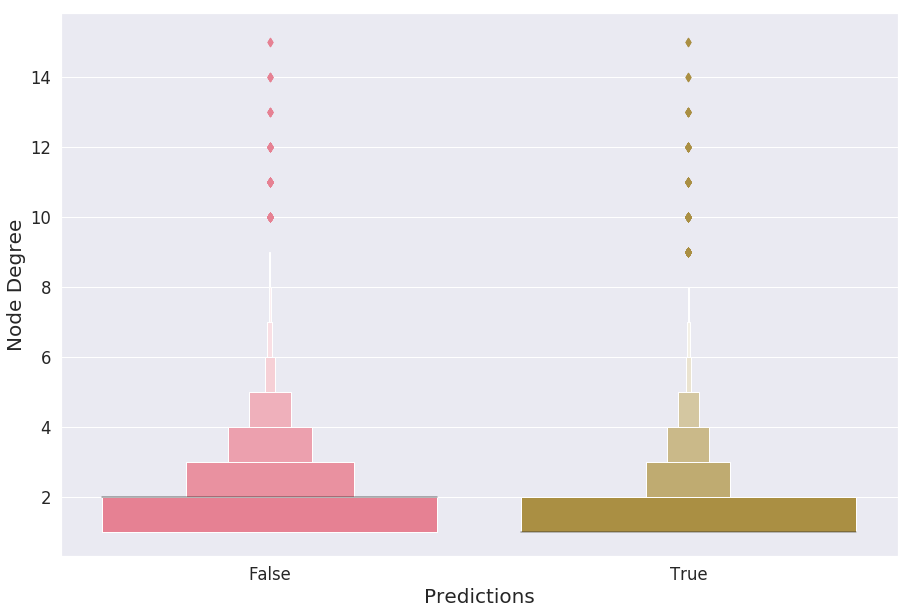

In [49]:
# Prepare data
plot_data = pd.concat([true_pred, false_pred]).reset_index(drop=True)

# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,10))

# Create plot
g = sns.boxenplot(x='NE', y='degree', data=plot_data)

# Add plot labels 
g.set_title('', fontsize=30)
g.set_xlabel('Predictions', fontsize=20)
g.set_ylabel('Node Degree', fontsize=20)

plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('../Images/{}.png'.format('ave_degree_boxenplot'))

From the boxenplot, we see that both predictions have outlier nodes with many neighbors. Although the two look similar, nodes with wrong predictions seem to have a slightly larger distribution of node with greater degrees than correct predictions.

In [50]:
mean_true = np.mean(true_pred.degree)
mean_false = np.mean(false_pred.degree)
print('Average node degree of correct predictions: {:.4f}'.format(mean_true))
print('Average node degree of wrong predictions: {:.4f}'.format(mean_false))

Average node degree of correct predictions: 1.4719
Average node degree of wrong predictions: 1.8932


After calculating the mean of degrees, the wrong predictions have a slightly larger value of 1.8932

Evaluating the performance on the development data, we see that the average degree for nodes with wrong predictions and correct predictions are quite similar. In both, majority of nodes have low degrees suggesting that they are from sparse areas of the network. Due to the lack of difference in node connectivity between the two groups, similarity measures relying on shared neighboring nodes may not be an effective method for predicting node attributes.

## 5. How well does homophily hold?

Homophiliy refers to the tendency for people to have ties with people who are similar to themselves in socially significant ways. (http://www.analytictech.com/mgt780/topics/homophily.htm)

Does homophily hold well with this particular dataset?
1. Create a subgraph of the original graph and see how similar attributes are between nodes that are linked together.  

### Create a random subgraph to analyze

In [51]:
# Choose a random node, get all neighbors. 
sub_nodes = list(grph.neighbors('6334893'))

# Re-add node '6334893' as it is not part of the list sub_nodes
sub_nodes.append('6334893')

small_graph = grph.subgraph(sub_nodes)

print("Number of edges: {}".format(small_graph.number_of_edges())) 
print("Number of nodes: {}".format(small_graph.number_of_nodes()))

Number of edges: 515
Number of nodes: 72


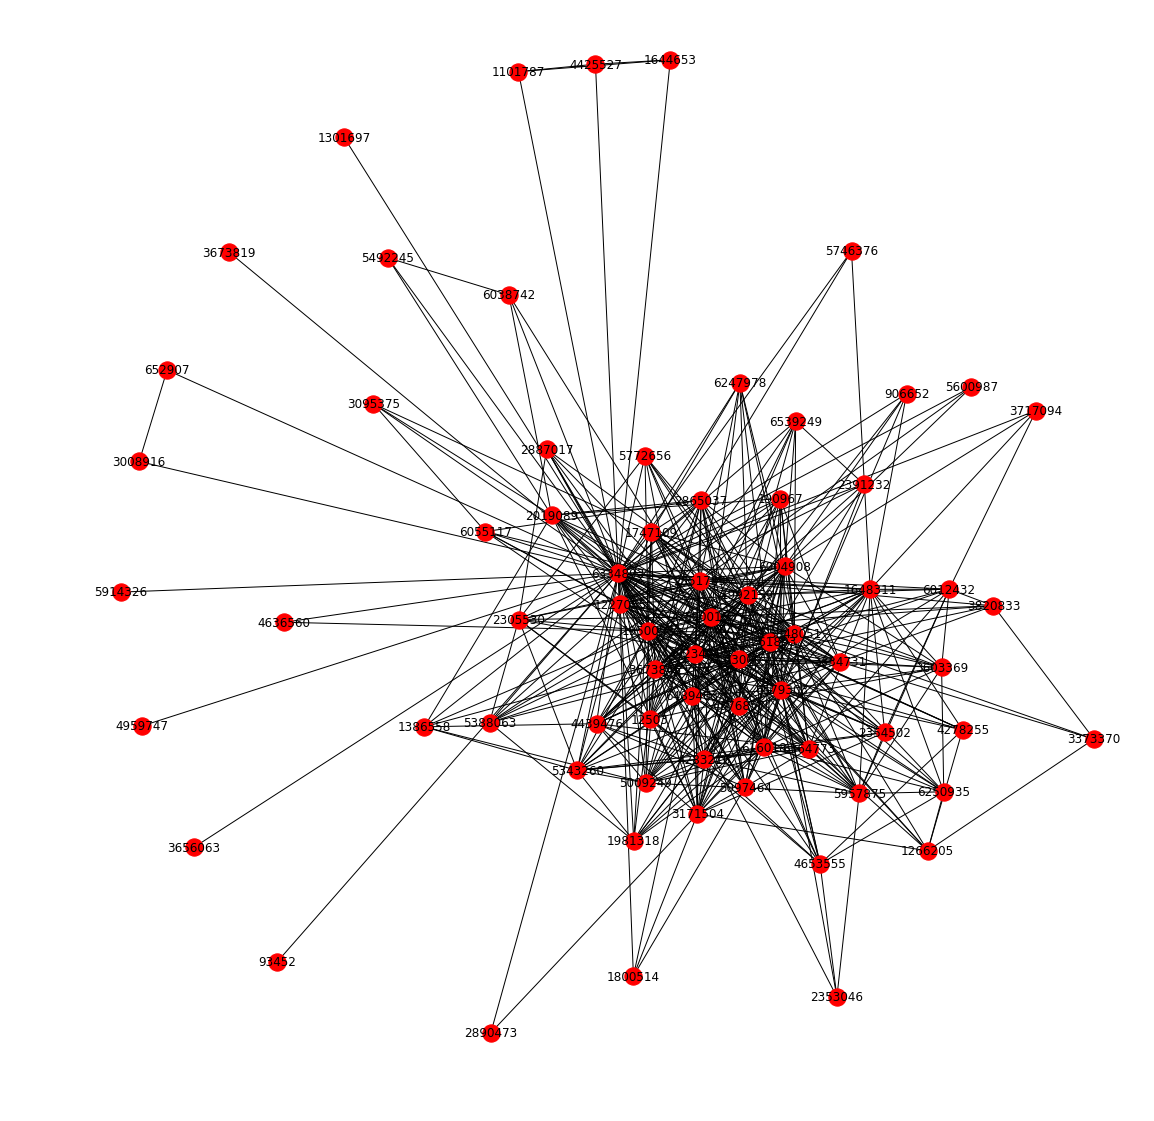

In [53]:
plt.figure(figsize=(15,15))
nx.draw(small_graph, with_labels=True)

In [62]:
all_nodes = pd.DataFrame({'nodes': small_graph.nodes()})
all_nodes.head()

,nodes
0,4278255
1,5388063
2,5600987
3,3656063
4,163000


In [63]:
all_nodes.nodes = all_nodes.nodes.astype(np.int64)
all_nodes = all_nodes.merge(tot_set, left_on='nodes', right_on='id', how='left')
all_nodes.head(3)

,nodes,id,attr
0,4278255,4278255.0,T0:0 T1:1
1,5388063,5388063.0,T0:0 T1:595
2,5600987,5600987.0,T0:0 T1:1005 T8:3


In [64]:
print('{} nan values'.format(all_nodes.isna().sum()))

nodes    0
id       1
attr     1
dtype: int64 nan values


We see that both id and attr column are nan. We do not know the attributes for this paritcular node, so remove this node.

In [65]:
all_nodes.dropna(inplace=True)
all_nodes.drop(['id'], inplace=True, axis=1)

### Check the distribution of attributes among nodes in subgraph

In [133]:
# Count attribute classes
attr_type_count = {}
    
for row in all_nodes.itertuples():
    if row[2]:
        # Split attribute by class and value
        for i in row[2].split():
            attr, val = i.split(':')
            attr_type_count[attr] = attr_type_count.get(attr, 0) + 1

In [67]:
for k, v in attr_type_count.items():
    print('{}/{} or {:.2f}% of nodes in the graph have attribute of class {}'.format(v, all_nodes.shape[0], (v/all_nodes.shape[0])*100,  k))

71/71 or 100.00% of nodes in the graph have attribute of class T0
71/71 or 100.00% of nodes in the graph have attribute of class T1
9/71 or 12.68% of nodes in the graph have attribute of class T8


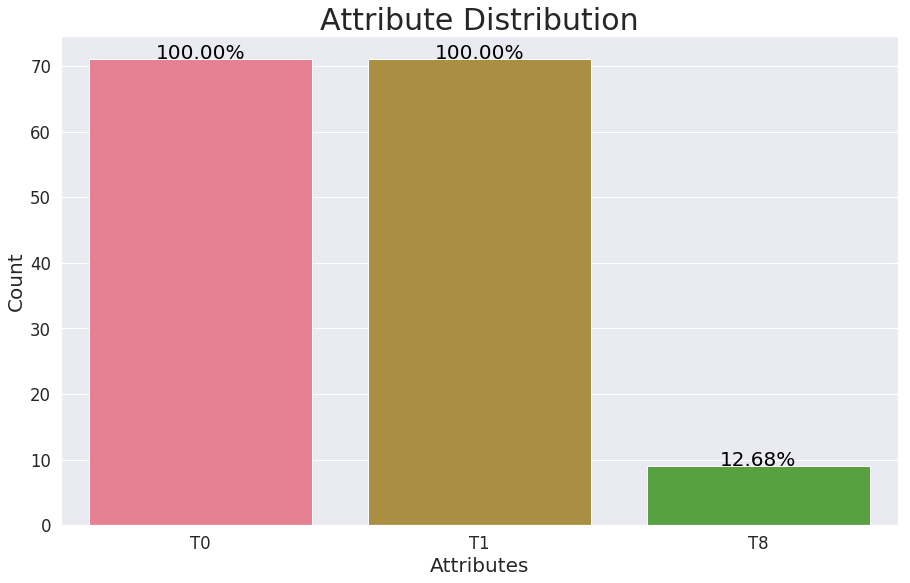

In [71]:
# Data preparation
plot_data = pd.DataFrame({'Attributes': list(attr_type_count.keys()),
                          'Count': list(attr_type_count.values())})

# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create plot
g = sns.barplot(x='Attributes', y='Count', data=plot_data)

# Add plot labels 
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Count', fontsize=20)
g.axes.set_title('Attribute Distribution', fontsize=30)
for i in plot_data.itertuples():
    g.text(x=i[0], y=i[2],  
           s='{:.2f}%'.format((i[2] / all_nodes.shape[0])*100), color='black', ha="center", size=20)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('../Images/{}.png'.format('Attribute_Distribution_of_Subgraph'))

All nodes in ths subgraph have T0 and T1 class attributes while signficantly less nodes (12.68%) have T8 class attributes. T8 classes are much rarer than compared to T0 and T1. 

## Check the amount of varieties per attribute class

In [72]:
# Count attribute classes
variation_by_class = {'T0': [],
                      'T1': [],
                      'T8': []}
    
for row in all_nodes.itertuples():
    if row[2]:
        # Split attribute by class and value
        for i in row[2].split():
            attr, val = i.split(':')
            variation_by_class[attr].append(val)

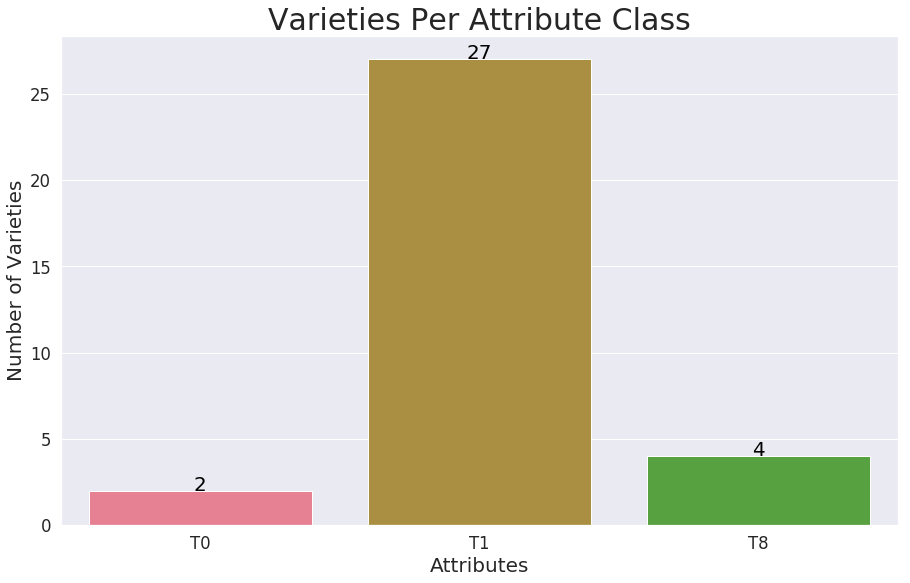

In [74]:
# Data preparation
plot_data = pd.DataFrame({'Attribute_class': list(variation_by_class.keys()),
                          'Count': [len(np.unique(variation_by_class[x])) for x in variation_by_class.keys()]})

# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create plot
g = sns.barplot(x='Attribute_class', y='Count', data=plot_data)

# Add plot labels 
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Number of Varieties', fontsize=20)
g.axes.set_title('Varieties Per Attribute Class', fontsize=30)
for i in plot_data.itertuples():
    g.text(x=i[0], y=i[2],  
           s='{}'.format(i[2]), color='black', ha="center", size=20)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('../Images/{}.png'.format('Varieties_Per_Attribute_Class'))

T0 and T8 class attributes a have the least variety, while T1 has many more. 

### Linked node pairs similarities and differences

In [157]:
node_1 = []
node_2 = []

for i in list(small_graph.edges()):
    # Separate tuple into two lists: node and the node its linked with
    node_1.append(i[0])
    node_2.append(i[1])

homophily_test = pd.DataFrame({
                        'n': node_1,
                        'v': node_2
                        })

print(homophily_test.shape[0])
homophily_test.head()

515


,n,v
0,4278255,4923461
1,4278255,1648311
2,4278255,1266205
3,4278255,4653555
4,4278255,6579303


In [135]:
# Convert 'n' and 'v' columns to int64 to match tot_set
homophily_test = homophily_test.astype(np.int64)

In [136]:
# Merge homphily_test dataframe with corresponding attributes to see if they overlap 
homophily_test = homophily_test.merge(tot_set, left_on='n', right_on='id', how='left')
homophily_test = homophily_test.merge(tot_set, left_on='v', right_on='id', how='left')
homophily_test.head()

,n,v,id_x,attr_x,id_y,attr_y
0,4278255,4923461,4278255.0,T0:0 T1:1,4923461,T0:0 T1:1
1,4278255,1648311,4278255.0,T0:0 T1:1,1648311,T0:0 T1:1
2,4278255,1266205,4278255.0,T0:0 T1:1,1266205,T0:0 T1:1
3,4278255,4653555,4278255.0,T0:0 T1:1,4653555,T0:0 T1:1
4,4278255,6579303,4278255.0,T0:0 T1:1,6579303,T0:0 T1:60 T8:0


In [137]:
homophily_test.drop(['id_x', 'id_y'], inplace=True, axis=1)
homophily_test.columns = ['n', 'v', 'attr_n', 'attr_v']
homophily_test.head()

,n,v,attr_n,attr_v
0,4278255,4923461,T0:0 T1:1,T0:0 T1:1
1,4278255,1648311,T0:0 T1:1,T0:0 T1:1
2,4278255,1266205,T0:0 T1:1,T0:0 T1:1
3,4278255,4653555,T0:0 T1:1,T0:0 T1:1
4,4278255,6579303,T0:0 T1:1,T0:0 T1:60 T8:0


In [138]:
# Check for rows with nan 
print('{} nan values'.format(homophily_test.isna().sum()))

n         0
v         0
attr_n    1
attr_v    0
dtype: int64 nan values


In [139]:
homophily_test.dropna(inplace=True)

In [140]:
# Find where attributes are the same or different
homophily_test = homophily_test.assign(NE=homophily_test['attr_n'] == homophily_test['attr_v'])
homophily_test.head()

,n,v,attr_n,attr_v,NE
0,4278255,4923461,T0:0 T1:1,T0:0 T1:1,True
1,4278255,1648311,T0:0 T1:1,T0:0 T1:1,True
2,4278255,1266205,T0:0 T1:1,T0:0 T1:1,True
3,4278255,4653555,T0:0 T1:1,T0:0 T1:1,True
4,4278255,6579303,T0:0 T1:1,T0:0 T1:60 T8:0,False


In [141]:
diff_attr = homophily_test[homophily_test.NE == False]
same_attr = homophily_test[homophily_test.NE == True]

In [142]:
print("{:.4f}% of linked node pairs share the same attribute".format(((same_attr.shape[0] / homophily_test.shape[0]) * 100)))
print("{:.4f}% of linked node pairs do not share the same attribute".format(((diff_attr.shape[0] / homophily_test.shape[0]) * 100)))

34.4358% of linked node pairs share the same attribute
65.5642% of linked node pairs do not share the same attribute


In [153]:
# Find instances when paired nodes have different attributes 
all_pair_difference = []
    
for row in diff_attr.itertuples():
    # Store attribute for comparison 
    node_attr = {}
    
    # First node attributes
    for i in row[3].split():
        attr, val = i.split(':')
        node_attr[attr] = val 
    
    # Store pair difference 
    difference = list(node_attr.keys())
    
    # Second node attributes
    for j in row[4].split():
        attr, val = j.split(':')
        # Check if attribute class was present in first node, then compare values 
        if attr in difference:
            if val == node_attr[attr]:
                difference.remove(attr)
        # If attribute class is not present in first node, treat as difference 
        else:
            difference.append(attr)
    
    # Store difference between pairs
    all_pair_difference.append(difference)

In [154]:
print('Difference between pairs:')
all_pair_difference = [str(x) for x in all_pair_difference]
all_pair_difference = pd.DataFrame({'attributes': all_pair_difference})
all_pair_difference.attributes.value_counts()

Difference between pairs:


['T1']          160
['T1', 'T8']    118
['T8']           58
['T0', 'T1']      1
Name: attributes, dtype: int64

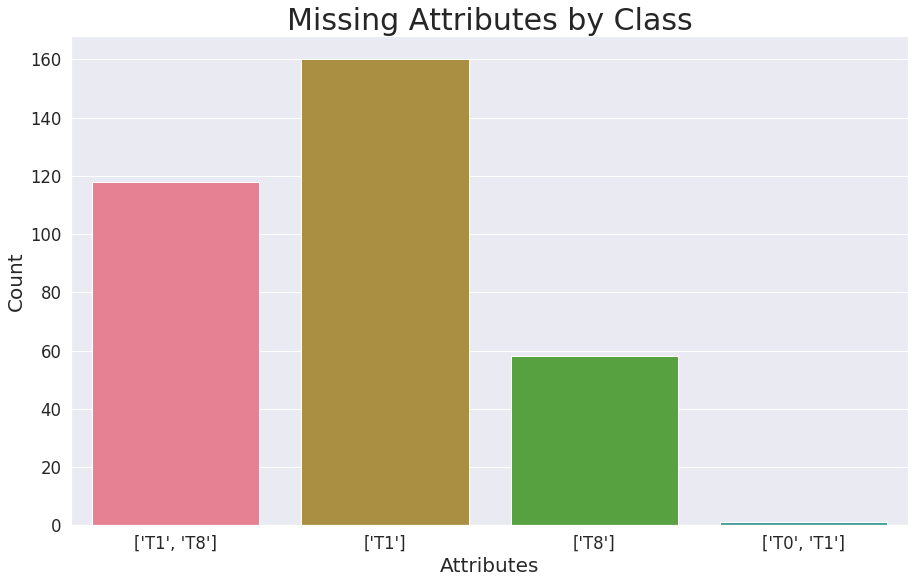

In [155]:
# Configure plot style 
sns.set(style='darkgrid', palette='husl', font_scale=1.5)
plt.figure(figsize=(15,9))

# Create the plot
g = sns.countplot(x='attributes', data=all_pair_difference)

# Fine Tuning font size
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Count', fontsize=20)
g.axes.set_title('Missing Attributes by Class', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('../Images/{}.png'.format('missing_attributes'))

For the particular dataset, homophily appears to hold well for some attribute classes, while it is poor for others. Again, homophily in a social context explains that people who share similarities in socially significant ways are more likely to be linked. To evaluate this, a subgraph of the original graph was created using the neighboring nodes of a randomly selected node. We then compared the attributes of all different linked node pairs. The results show that out of 515 pairs, nearly all of them shared the same T0 class attribute and only 1 pair had differences. The second attribute class with the most difference was T8, and the highest difference was observed with attribute class T1. 

Perhaps, the results suggest that T0 is a more socially significant trait than T1 or T8. It is also interesting to see that many nodes who had different T1 traits also had different T8 traits which could suggest some "coupled" relationship between attributes. An important limitation, however, is that we do not know what these traits actually are since they have been deidentified. 

## Future Approaches 